## Using Exponential Moving Averages to detect an outburst.
This notebook uses synthetic data to measure the performance of the EMA attributes for
discovering a step changein a signsl, in the presence of gaussian noise.

In [17]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import json
import random

These parameters define the model of the signal. 
We use nstep timesteps to cover the range from tstart to tend. 
The standard deviation of the gaussian noise is sigma.
The imposed step signal will start at tburst.

In [18]:
sigma = 0.1        # error bar of signal
nstep = 1000        # number of points
tstart = 57000.0   # time range
tend   = 60000.0
tburst = (tstart + tend)/2
print ('average dt is ', (tend - tstart)/nstep)

average dt is  3.0


# Synthesise the signal
This function makes a list of sample times, with the intervals exponentially distributed,
then builds the random variable dc_mag, and computes the EMAs for 2 days, 8 days, and 28 days, 
using the recursion relation.

In [19]:
def synth(step, duration):
    gtlist = []
    jd = 0
    for i in range(nstep):
        gtlist.append(jd)
        jd += 0.5+ random.expovariate(1.0)
#        jd += 1
    for i in range(nstep):
        gtlist[i] = tstart + gtlist[i] *(tend-tstart)/gtlist[nstep-1]
        
    g02 = g08 = g28 = 0.0
    lg02 = []
    lg08 = []
    lg28 = []
    gmags = []

    oldgjd = 0.0
    for i in range(nstep):
        jd = gtlist[i]
        dc_mag = random.gauss(0.0, sigma)

        if jd > tburst and jd < tburst + duration:
            dc_mag += step
        gmags.append(dc_mag)
        
        f02 = math.exp(-(jd-oldgjd)/2.0)
        f08 = math.exp(-(jd-oldgjd)/8.0)
        f28 = math.exp(-(jd-oldgjd)/28.0)
        
        g02 = g02*f02 + dc_mag*(1-f02)
        g08 = g08*f08 + dc_mag*(1-f08)
        g28 = g28*f28 + dc_mag*(1-f28)
        
        lg02.append(g02)
        lg08.append(g08)
        lg28.append(g28)
        oldgjd = jd

    return {'gtlist':np.array(gtlist), 'gmags':np.array(gmags),
            'g02':np.array(lg02), 'g08':np.array(lg08), 'g28':np.array(lg28)}

# Plot results
This function makes a plot of the noise-free signal in blue, the signal in balck
with markers, then the three EMAs in shades of grey. Those points labelled
as outburst have larger red markers.

In [20]:
def plotit(d, outburst_list):
    plt.figure(figsize=(8,8))
    plt.plot(
        [tstart, tburst, tburst, tburst+duration, tburst+duration, tend], 
        [0,      0,  step,        step, 0, 0], 'k-', color="blue")
    plt.plot(d['gtlist'], d['g02'],   color=(0.5, 0.5, 0.5))
    plt.plot(d['gtlist'], d['g08'],   color=(0.6, 0.6, 0.6))
    plt.plot(d['gtlist'], d['g28'],   color=(0.8, 0.8, 0.8))
    plt.plot(d['gtlist'], d['gmags'], color=(0.0, 0.0, 0.0), marker='o', markersize=4)
    for i in outburst_list:
        t = d['gtlist'][i]
        m = d['gmags'][i]
        plt.plot([t], [m], marker='o', markersize=10, color="red")

    plt.axis(xmin=tburst-30, xmax=tburst+30)
    plt.axis(ymin=-0.25, ymax=0.4)
    plt.xlabel("Time")
    plt.ylabel("signal")
    plt.title('Detecting a step')
#plt.gca().invert_yaxis()
    plt.show()

# Run a statistical experiment
For a given instance of the timesteps and signal, compute the statistics of choice: 
false alarm rate and the time to first detection of the imposed step.

In [21]:
def experiment(d, L):
    p = (d['gmags'])/sigma
    q = (d['g02'])/sigma
    r = (d['g08'])/sigma
    s = (d['g28'])/sigma

    nfalse = nnoburst = 0
    first_detection = True
    first = duration
    outburst_list = []
    for i in range(len(d['gtlist'])):
        t = d['gtlist'][i]
        inburst = (t > tburst and t < tburst+duration)
        if not inburst:
            nnoburst += 1
#        if q[i] - s[i] > L and r[i] - s[i] > L and q[i] > r[i]:
#        if p[i] > 3*L :
        if q[i] > r[i] and r[i] > s[i] + L :
            if inburst:
                if first_detection:
                    first = t-tburst
                    first_detection = False
            else:
                nfalse += 1
            outburst_list.append(i)

    return {'outburst_list': outburst_list, 'falsepos':float(nfalse)/nnoburst, 'first':first}

# Make a plot
Choose the step size as 2 sigma, and the outburst criterion L as 1, then make the plot

step 3.0 L 1.0 falpos 0.000, first = 11.4


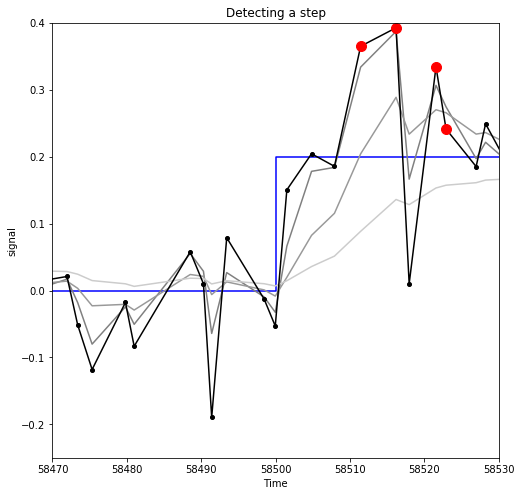

In [22]:
duration = 100       # True for ramp else step
step = 2*sigma  # step size or slope of ramp
L = 1
d = synth(step, duration)
r = outburst_list = experiment(d, L)
print('step %.1f L %.1f falpos %.3f, first = %.1f' % 
        (3, L, r['falsepos'], r['first']))
plotit(d, r['outburst_list'])

# Compute average of ensemble statistics
We run the experiment 100 times, for a range of step sizes and L values, 
and make a graph of the results.

In [23]:
def ensemble(step, duration, L):
    avgfalsepos = 0
    avgfirst = 0
    n = 100
    for i in range(n):
        d = synth(step, duration)
        r = outburst_list = experiment(d, L)
        avgfalsepos += r['falsepos']
        avgfirst    += r['first']
#    print('ramp/sigma %.1f L %.1f falpos %.3f, first = %.1f' % 
#          (ramp/sigma, L, avgfalsepos/n, avgfirst/n))
#    plotit(d, r['outburst_list'])
    return {'avgfalsepos':avgfalsepos/n, 'avgfirst':avgfirst/n}

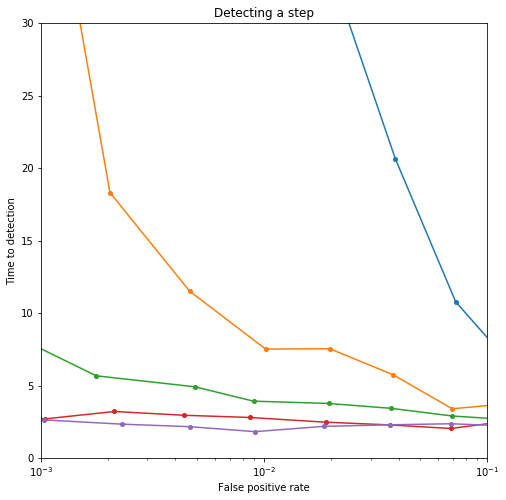

In [24]:
plt.figure(figsize=(8,8))
duration = 100       # True for ramp else step
for r in [1,2,3,5,10]:
    step = r*sigma  # step size or slope of ramp
    falsepos = []
    first   = []
    for i in range(1,16):
        L = 0.1*i
        q = ensemble(step, duration, L)
        falsepos.append(q['avgfalsepos'])
        first.append(q['avgfirst'])
    plt.plot(np.array(falsepos), np.array(first), marker='o', markersize=4)
plt.xscale('log')
plt.xlabel("False positive rate")
plt.ylabel("Time to detection")
plt.title('Detecting a step')
plt.axis(ymin=0, ymax=30)
plt.axis(xmin=0.001, xmax=0.1)
plt.show()